In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import time

# Input data for physics-informed generative model solving PDE equations

## 1. Laplace equation
$$ \frac {\partial^2 T}{\partial x^2} +  \frac {\partial^2 T}{\partial x^2} = 0 $$

This is an eclipitic equation and could have two types of boundary condition, Neumann BC and Dirichelet BC

For Dirichlet BC, the value of the variable T is fixed, while on Neumann BC the value is related to relation between neighbour nodes.

### Dirichlet boundary condition:



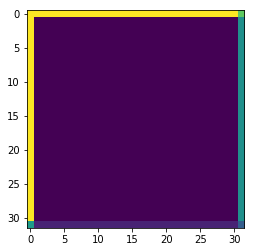

In [36]:
T = torch.zeros(1,1,32,32)
top, bottom, left, right = 100, 10, 100, 50
T[:,:,0,:] = top
T[:,:,-1,:] = bottom
T[:,:,:,0] = left
T[:,:,:,-1] = right
    
T[:,:,0,0] = (top + left) / 2
T[:,:,0,-1] = (top + right) / 2
T[:,:,-1,0] = (bottom + left) / 2
T[:,:,-1,-1] = (bottom + right) / 2
plt.imshow(T.cpu().detach().numpy()[0,0,:,:], vmin = 0, vmax = 100, cmap = plt.cm.viridis)

### Neumann boundary condition:

Supose one of the boundary, say, left boundary, contains Neumann BC:
$$\frac{\partial T}{\partial x} = a$$
On top the original setup for Dirichlet BC, we make use of the most externel nodes to be the indicator of the information from Neumann BC

Normalize all the data into 0 to 1. And fixed the geometry of the domain to be L = 1 

In [32]:
L = 1
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
print(dtype)

<class 'torch.cuda.FloatTensor'>


In [14]:
def get_solution(input_T, isNeum, dtype = torch.cuda.FloatTensor):
    "FDM method to solve laplace eqn"
    "a denotes the Neumann boundary condition at X = 0"
    maxIter = 1e8
    padT = input_T[0,0,:,:].numpy()
    output_T = input_T.clone().numpy()
    # READ NEUMANN BC FROM INPUT_T
    if isNeum[0]:
        nbc_left = padT[2:-2,0]
        print(nbc_left)
    if isNeum[1]:
        nbc_upper = padT[0,2:-2]
    if isNeum[2]:
        nbc_right = padT[2:-2,-1]
    if isNeum[3]:
        nbc_bottom = padT[-1,2:-2]
    
    # Acquire the real compute domain of T   
    T = padT[1:-1,1:-1]
    h = L / np.size(padT[0,:])
    T_new = np.copy(T)
    iteration = 0
    while iteration < maxIter:
        T_new[1:-1, 1:-1] = ((T_new[0:-2, 1:-1] + T_new[2:, 1:-1]) + (T_new[1:-1,0:-2] + T_new[1:-1, 2:]))*0.25
        if isNeum[0]:
            T_new[1:-1,0] = 1/3 * (4*T_new[1:-1,1] - T_new[1:-1, 2]  - 2*h*nbc_left)       
        err = (T_new - T).flat
        err = np.sqrt(np.dot(err,err))
        if err <= 1e-12:
            output_T[0,0,1:-1,1:-1] = T_new
            return torch.from_numpy(output_T).type(dtype)
        T = np.copy(T_new)
        iteration += 1
    output_T[0,0,1:-1,1:-1] = T_new    
    return torch.from_numpy(output_T).type(dtype)


[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001]


Text(0,0.5,'Y')

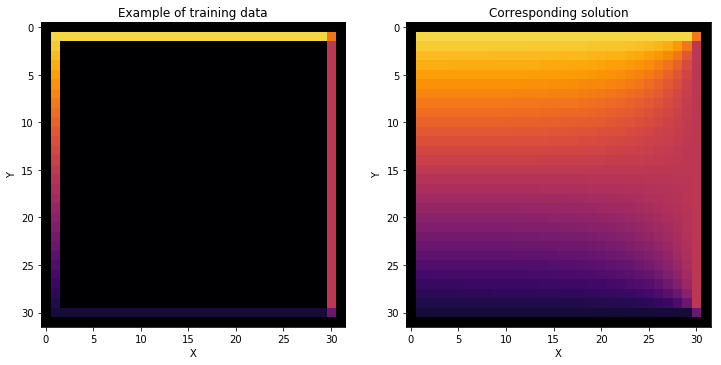

In [31]:
size = 32
T = torch.zeros(1,1,size,size)
isNeum = [True, False, False, False]
nbc = [0.001,0,0,0]
top, bottom, left, right = 0.9, 0.1, 0.1, 0.5

T[:,:,1,1:-1] = top
T[:,:,-2,1:-1] = bottom
T[:,:,1:-1,1] = left
T[:,:,1:-1,-2] = right

T[:,:,1,1] = (top + left) / 2
T[:,:,1,-2] = (top + right) / 2
T[:,:,-2,1] = (bottom + left) / 2
T[:,:,-2,-2] = (bottom + right) / 2


if isNeum[0]:
    T[:,:,1:-1,1] = torch.linspace(top,bottom,steps=size-2)
    T[:,:,2:-2,0] = nbc[0]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12, 6])

ax1.imshow(T.detach().numpy()[0,0,:,:], vmin=0, vmax=1, cmap=plt.cm.inferno)
ax1.set_title("Example of training data")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")

sol = get_solution(T,[True, False, False, False])
ax2.imshow(sol.cpu().detach().numpy()[0,0,:,:], vmin=0, vmax=1, cmap=plt.cm.inferno)
ax2.set_title("Corresponding solution")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")

Text(0.5,0.98,'Take a look at the left boundary')

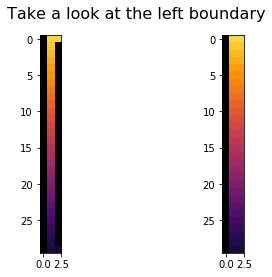

In [29]:
bd = T[:,:,1:-1,0:3].type(dtype)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(bd.cpu().detach().numpy()[0,0,:,:], vmin=0, vmax=1, cmap=plt.cm.inferno)
bdsol = sol[:,:,1:-1,0:3].type(dtype)
ax2.imshow(bdsol.cpu().detach().numpy()[0,0,:,:], vmin=0, vmax=1, cmap=plt.cm.inferno)
fig.suptitle('Take a look at the left boundary', fontsize=16)